<a href="https://colab.research.google.com/github/Cpt-Shaan/RL-Implementations/blob/main/Stock-Env/1min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finrl
!pip install pandas_ta
!pip install stable_baselines3
!pip install alpaca-trade-api
!pip install exchange-calendars
!pip install stockstats
!pip install wrds
!pip install websockets
!pip install websocket_client
!pip install pyfolio-reloaded

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=3a1b594f15fb76852bcc9e2adeacb67bc26d614ba962ab1406304108db31ee20
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import pandas as pd
import numpy as np
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3 import PPO, A2C, DDPG, TD3, SAC
from stable_baselines3.common.logger import configure
import pandas_ta as ta

In [ ]:
import zipfile

In [ ]:
zip_file_path = '/content/drive/MyDrive/train_filtered.zip'
extract_to_path = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [ ]:
train_df = pd.read_csv("train_filtered.csv", parse_dates=['date'])

In [ ]:
test_df = pd.read_csv("test_filtered.csv", parse_dates=['date'])

In [ ]:
DATA_DIR = 'one-min-dataset'
SAVE_DATA_DIR = 'one-min-processed'

In [ ]:
def calculate_beta_for_stocks(data_dir):
    # List all files in the directory
    all_files = os.listdir(data_dir)

    # Filter only CSV files with the pattern *_15minute_ohlcv.csv
    ohlcv_files = [f for f in all_files if f.endswith('_minute_ohlcv.csv')]

    # Extract stock names and filter out BSE/NIFTY (except the reference index)
    stock_names = []
    for f in ohlcv_files:
        stock = f.replace('_minute_ohlcv.csv', '')
        if not (stock.startswith('BSE') or stock.startswith('NIFTY') or stock == 'NIFTY-50.NSE'):
            stock_names.append(stock)

    # Load NIFTY-50 index data
    nifty_file = 'NIFTY-50.NSE_minute_ohlcv.csv'
    nifty_path = os.path.join(data_dir, nifty_file)
    if not os.path.exists(nifty_path):
        raise FileNotFoundError(f"Reference index file {nifty_file} not found in {data_dir}")
    nifty_df = pd.read_csv(nifty_path, parse_dates=['timestamp'])
    nifty_df['date'] = pd.to_datetime(nifty_df['timestamp'])
    nifty_df['return'] = nifty_df['close'].pct_change()

    # Calculate beta for each stock
    beta_values = {}
    for stock in stock_names:
        file_path = os.path.join(data_dir, f"{stock}_minute_ohlcv.csv")
        stock_df = pd.read_csv(file_path, parse_dates=['timestamp'])
        stock_df['date'] = pd.to_datetime(stock_df['timestamp'])
        stock_df['return'] = stock_df['close'].pct_change()

        # Merge with NIFTY returns on date
        combined = pd.merge(
            stock_df[['date', 'return']],
            nifty_df[['date', 'return']],
            on='date',
            suffixes=('_stock', '_nifty')
        ).dropna()

        # Calculate beta: cov(stock, nifty) / var(nifty)
        cov = np.cov(combined['return_stock'], combined['return_nifty'])[0, 1]
        var = np.var(combined['return_nifty'])
        beta = cov / var if var != 0 else np.nan
        beta_values[stock] = beta

    # Sort stocks by beta in decreasing order
    sorted_beta = sorted(beta_values.items(), key=lambda x: x[1], reverse=True)

    # Display results
    print("Stocks sorted by beta (relative to NIFTY-50):")
    for stock, beta in sorted_beta:
        print(f"{stock}: {beta:.6f}")

    return sorted_beta

# Run the function
# sorted_beta = calculate_beta_for_stocks(DATA_DIR)

In [ ]:
'''
beta_df = pd.DataFrame(sorted_beta, columns=['Stock', 'Beta'])
beta_df.to_csv('sorted_betas_one_min.csv', index=False)
'''

In [ ]:
def process_single_stock_1min(data_dir, stock_name, dir_to_save):
    """
    Processes a single 1-minute OHLCV stock file into FinRL-compatible format
    - Fills missing values
    - Adds RSI and MACD indicators
    - Saves processed file as 'stockname-processed_minute_ohlcv.csv'

    Args:
        data_dir (str): Directory containing OHLCV files
        stock_name (str): Stock name (without '_minute_ohlcv.csv')

    Returns:
        pd.DataFrame: Processed DataFrame
    """
    # Read raw data
    file_path = os.path.join(data_dir, f"{stock_name}_minute_ohlcv.csv")
    df = pd.read_csv(file_path, parse_dates=['timestamp'])

    # Create complete 1-minute index
    df = df.sort_values('timestamp')
    df = df.set_index('timestamp')
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq='1T')
    df = df.reindex(full_idx)

    # Fill OHLC prices
    df['close'] = df['close'].ffill().bfill()
    for col in ['open', 'high', 'low']:
        df[col] = df[col].fillna(df['close'])

    # Fill volume and add indicators
    df['volume'] = df['volume'].fillna(0)
    df['rsi'] = ta.rsi(df['close'], length=14)
    macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
    df['macd'] = macd['MACD_12_26_9']

    # Final processing
    df = df.ffill().bfill()
    df = df.reset_index().rename(columns={'index': 'date'})
    df['tic'] = stock_name

    # Save processed file
    save_path = os.path.join(dir_to_save, f"{stock_name}-processed_minute_ohlcv.csv")
    df.to_csv(save_path, index=False)

    print(f"Processed {stock_name} | Rows: {len(df)} | Saved to {save_path}")
    return df


In [ ]:
'''
for i in range(1,70):
    if(sorted_betas[i].endswith('NSE')):
        process_single_stock_1min(DATA_DIR, sorted_betas[i], SAVE_DATA_DIR)
'''

In [ ]:
def combine_processed_dfs_filtered(data_dir, train_start, train_end, test_start, test_end, processed_files=None):
    """
    Combines processed stock DataFrames into single FinRL-compatible DataFrame
    filtered by date range and saves to CSV.

    Note:
        FinRL has its own data-split method, however this method was written since processing a single processed
        full-df of around 7GBs would be very heavy on the RAM and time-consuming.

    Args:
        data_dir (str): Directory containing processed files
        train_start (str): Start datetime string for train dataset (e.g., '2021-01-01 09:15:00+05:30')
        train_end (str): End datetime string for test dataset (e.g., '2024-12-31 15:29:00+05:30')
        test_start (str) : ;; ;; ;; For test dataset
        test_end (str) : ;; ;; ;; For test dataset
        processed_files (list): Optional list of specific files to combine

    Returns:
        pd.DataFrame: Combined filtered train and test DataFrame sorted by date and ticker
    """
    if processed_files is None:
        # Find all processed files in directory
        processed_files = [f for f in os.listdir(data_dir)
                          if f.endswith('-processed_minute_ohlcv.csv')]

    train_dfs = []
    test_dfs = []
    for file in processed_files:
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path, parse_dates=['date'])

        # Filter by date range
        tdf = df[(df['date'] >= train_start) & (df['date'] <= train_end)]
        train_dfs.append(tdf)

        df = df[(df['date'] >= test_start) & (df['date'] <= test_end)]
        test_dfs.append(df)

        print(f"Added {file} to train and test processed-csv")

    combined_train_df = pd.concat(train_dfs, ignore_index=True)
    combined_test_df = pd.concat(test_dfs, ignore_index=True)
    combined_train_df = combined_train_df.sort_values(['date', 'tic'])
    combined_test_df = combined_test_df.sort_values(['date', 'tic'])

    # Save combined data

    combined_train_df.to_csv("train_filtered.csv", index=False)
    combined_test_df.to_csv("test_filtered.csv", index=False)

    print(f"Combined {len(processed_files)} files with date filter from {train_start} to {train_end} | Total rows: {len(combined_train_df)}")

    return combined_train_df, combined_test_df

In [ ]:
"""
# Optional to ensure same timesteps for all stocks
date_counts = combined_filtered_df.groupby('date').size()
if not (date_counts == 32).all():
    missing_dates = date_counts[date_counts != 32].index
    print(f"Warning: {len(missing_dates)} dates have incomplete data")
    # Drop incomplete dates for stability
    combined_filtered_df = combined_filtered_df[~combined_filtered_df['date'].isin(missing_dates)]
"""

In [ ]:
INDICATORS = ['rsi', 'macd']
TRAIN_START = '2023-01-01 09:15:00+05:30'
TRAIN_END = '2024-01-01 15:29:00+05:30'
TEST_START = '2024-01-02 09:15:00+05:30'
TEST_END = '2024-12-31 15:29:00+05:30'
INITIAL_AMOUNT = 1000000
HMAX = 100

In [ ]:
train_df, test_df = combine_processed_dfs_filtered(SAVE_DATA_DIR, TRAIN_START, TRAIN_END, TEST_START, TEST_END)

In [ ]:
train_df = data_split(train_df, TRAIN_START, TRAIN_END)
test_df = data_split(test_df, TEST_START, TEST_END)

In [ ]:
train_df

,date,open,high,low,close,volume,oi,rsi,macd,tic
0,2023-01-01 09:15:00+05:30,3850.00,3850.0,3850.00,3850.00,0.0,0.0,33.728665,-2.273737e-12,ADANIENT.NSE
1,2023-01-01 09:15:00+05:30,819.00,819.0,819.00,819.00,0.0,0.0,53.894561,7.958079e-13,ADANIPORTS.NSE
2,2023-01-01 09:15:00+05:30,300.80,300.8,300.80,300.80,0.0,0.0,59.630178,2.273737e-13,ADANIPOWER.NSE
3,2023-01-01 09:15:00+05:30,310.10,310.1,310.10,310.10,0.0,0.0,47.478945,0.000000e+00,AJMERA.NSE
4,2023-01-01 09:15:00+05:30,112.00,112.0,112.00,112.00,0.0,0.0,47.841276,-7.105427e-14,ANANTRAJ.NSE
...,...,...,...,...,...,...,...,...,...,...
16831195,2024-01-01 15:29:00+05:30,1548.05,1548.5,1547.00,1548.25,5641.0,0.0,35.738670,-1.414990e+00,INFY.NSE
16831196,2024-01-01 15:29:00+05:30,123.40,123.4,123.35,123.40,39226.0,0.0,49.959293,-2.285111e-02,IOC.NSE
16831197,2024-01-01 15:29:00+05:30,466.00,466.0,465.50,465.80,31063.0,0.0,24.334484,-8.535840e-01,ITC.NSE
16831198,2024-01-01 15:29:00+05:30,212.20,212.5,211.80,212.25,11014.0,0.0,73.312590,4.719702e-01,JINDALSAW.NSE


In [ ]:
test_df

,date,open,high,low,close,volume,oi,rsi,macd,tic
0,2024-01-02 09:15:00+05:30,2922.00,2922.00,2905.05,2909.00,20216.0,0.0,1.000000e+02,0.398860,ADANIENT.NSE
1,2024-01-02 09:15:00+05:30,1047.85,1048.50,1044.00,1046.85,33833.0,0.0,1.000000e+02,0.458689,ADANIPORTS.NSE
2,2024-01-02 09:15:00+05:30,525.00,525.00,522.30,522.30,10592.0,0.0,1.072780e-32,-0.127635,ADANIPOWER.NSE
3,2024-01-02 09:15:00+05:30,449.10,451.45,449.10,449.10,1214.0,0.0,1.000000e+02,0.167521,AJMERA.NSE
4,2024-01-02 09:15:00+05:30,303.20,305.25,303.00,305.00,54216.0,0.0,1.000000e+02,0.434758,ANANTRAJ.NSE
...,...,...,...,...,...,...,...,...,...,...
16785115,2024-12-31 15:29:00+05:30,1884.00,1887.00,1882.95,1885.65,19067.0,0.0,6.753804e+01,1.567250,INFY.NSE
16785116,2024-12-31 15:29:00+05:30,136.28,136.44,136.20,136.44,34459.0,0.0,5.213644e+01,-0.054498,IOC.NSE
16785117,2024-12-31 15:29:00+05:30,484.15,484.50,484.10,484.45,58500.0,0.0,6.591386e+01,0.345365,ITC.NSE
16785118,2024-12-31 15:29:00+05:30,291.30,292.70,291.15,292.50,2123.0,0.0,5.632508e+01,0.162457,JINDALSAW.NSE


In [ ]:
# Transaction cost configuration for Indian market
def get_indian_transaction_costs(stock_dim):
    # Base costs (as percentages of trade value)

    # 0.03% brokerage
    base_buy_cost = 0.000603  # 0.015% stamp duty + 0.00297% transaction + 0.0001% SEBI + 0.0001% IPFT
    base_sell_cost = 0.000603  # Same components as buy

    # STT (applies differently to delivery vs intraday)
    # stt_delivery = 0.001  # 0.1% on both sides
    stt_intraday = 0.00025  # 0.025% on sell only

    # GST approximation (18% of base costs)
    gst_multiplier = 0.18

    '''
    # Calculate final costs (for non-intraday trading)
    buy_cost_delivery = (base_buy_cost * (1 + gst_multiplier)) + stt_delivery
    sell_cost_delivery = (base_sell_cost * (1 + gst_multiplier)) + stt_delivery
    '''

    # For daily OHLCV considering trades are closed intraday only.
    buy_cost_intraday = (base_buy_cost * (1 + gst_multiplier))
    sell_cost_intraday = (base_sell_cost * (1 + gst_multiplier)) + stt_intraday

    # For intraday trading environment:
    buy_cost_list = [buy_cost_intraday] * stock_dim
    sell_cost_list = [sell_cost_intraday] * stock_dim

    return buy_cost_list, sell_cost_list

In [ ]:
# 4. Environment setup
stock_dim = 32
state_space = 1 + 2*stock_dim + len(INDICATORS)*stock_dim
buy_cost_list, sell_cost_list = get_indian_transaction_costs(stock_dim)
num_stock_shares = [0] * stock_dim

print(stock_dim, state_space)

32 129


In [ ]:
env_kwargs = {
    "hmax": HMAX,
    "initial_amount": INITIAL_AMOUNT,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dim,
    "tech_indicator_list": ['rsi', 'macd'],
    "action_space": stock_dim,
    "reward_scaling": 1e-4
}

# Verify state space calculation
print(f"Calculated state space: {state_space}")
print(f"Unique stocks in train: {train_df['tic'].nunique()}")
print(f"Unique dates in train: {train_df['date'].nunique()}")


Calculated state space: 129
Unique stocks in train: 32
Unique dates in train: 525974


In [ ]:
# 5. Create environments with validation
def create_env(df, env_kwargs):
    env = StockTradingEnv(df=df, **env_kwargs)
    # Validate state dimension
    obs = env.reset()
    if len(obs[0]) != env_kwargs['state_space']:
        print(f"CRITICAL: State dim mismatch. Expected {env_kwargs['state_space']}, got {len(obs)}")
        print(f"Components: [Balance] + [Prices] + [Holdings] + [Indicators]")
        print(f"1 + {stock_dim} + {stock_dim} + {stock_dim * len(INDICATORS)}")
    return env

train_env = create_env(train_df, env_kwargs)

In [ ]:
type(train_env)

finrl.meta.env_stock_trading.env_stocktrading.StockTradingEnv

In [ ]:
obs = train_env.reset()
print(len(obs))
print(obs[0])
print(obs[1])
print(len(obs[0]))
print(len(obs[1]))

2
[1000000, 3850.0, 819.0, 300.8, 310.1, 112.0, 17.2, 3085.0, 934.9, 3628.2, 1547.0, 6577.0, 88.35, 100.0, 808.4, 1077.0, 194.05, 41.4, 374.5, 81.3, 1715.2, 19.35, 1037.0, 1630.0, 2564.0, 322.0, 13.8, 285.5, 1508.6, 61.45, 331.0, 51.9, 583.45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33.72866485488211, 53.89456088304852, 59.63017773921656, 47.47894465288032, 47.841275996838576, 65.97030971193058, 48.03941786490167, 52.51820285874838, 73.02452715027374, 40.468355139099295, 48.17464495101893, 49.26216281732158, 52.19595305081474, 63.35778390987185, 53.96679906182924, 48.653143168601126, 49.43853012904164, 39.55425862267765, 53.9836948115265, 39.0039792837893, 59.68518247360719, 23.617516651723623, 52.60066234877076, 54.9577827882091, 51.06014033889083, 48.503394328006735, 51.89070794834343, 49.860184371141344, 44.08903999962996, 34.72101870685445, 51.59016371078173, 57.943181555854544, -2.273736754432321e-12, 7.958078640513122e-13, 2

In [ ]:
train_env = train_env.get_sb_env()[0]

In [ ]:
type(train_env)

stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv

In [ ]:
# 6. Initialize DRL Agent
agent = DRLAgent(env=train_env)

In [ ]:
print(train_df.groupby('tic').size())  # Should be equal for all stocks
print(train_df[['tic', 'date', 'rsi', 'macd']].isna().sum())

tic
ADANIENT.NSE      525974
ADANIPORTS.NSE    525974
ADANIPOWER.NSE    525974
AJMERA.NSE        525974
ANANTRAJ.NSE      525974
ASHIMASYN.NSE     525974
ASIANPAINT.NSE    525974
AXISBANK.NSE      525974
BAJAJ-AUTO.NSE    525974
BAJAJFINSV.NSE    525974
BAJFINANCE.NSE    525974
BANKINDIA.NSE     525974
BEL.NSE           525974
BHARTIARTL.NSE    525974
CIPLA.NSE         525974
COALINDIA.NSE     525974
DHANI.NSE         525974
DLF.NSE           525974
EMBDL.NSE         525974
GRASIM.NSE        525974
HCC.NSE           525974
HCLTECH.NSE       525974
HDFCBANK.NSE      525974
HINDUNILVR.NSE    525974
HINDZINC.NSE      525974
IFCI.NSE          525974
INDIANB.NSE       525974
INFY.NSE          525974
IOC.NSE           525974
ITC.NSE           525974
JINDALSAW.NSE     525974
JINDALSTEL.NSE    525974
dtype: int64
tic     0
date    0
rsi     0
macd    0
dtype: int64


In [ ]:
# Training PPO
ppo_params = {
    'n_steps': 128,         # Changed from 2048
    'ent_coef': 0.01,
    'learning_rate': 0.0003, # Changed from 0.00025
    'batch_size': 128        # Changed from 64
}

model_ppo = agent.get_model('ppo', model_kwargs=ppo_params)
# Set up logger
tmp_path = os.path.join('results_one_min', 'ppo')
logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
model_ppo.set_logger(logger)

# Train model
trained_model_ppo = agent.train_model(
    model=model_ppo,
    tb_log_name='ppo',
    total_timesteps=1000
)

trained_model_ppo.save(os.path.join('trained_one_min', f"agent_ppo"))

{'n_steps': 128, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Logging to results_one_min/ppo


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-------------------------------------
| time/              |              |
|    fps             | 0            |
|    iterations      | 1            |
|    time_elapsed    | 288          |
|    total_timesteps | 128          |
| train/             |              |
|    reward          | -0.034557763 |
-------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 0            |
|    iterations           | 2            |
|    time_elapsed         | 563          |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.045572385  |
|    clip_fraction        | 0.309        |
|    clip_range           | 0.2          |
|    entropy_loss         | -45.4        |
|    explained_variance   | -0.374       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.521       |
|    n_updates            | 10           |
|    policy_g

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'trained_one_min' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [ ]:
model_a2c = agent.get_model('a2c')
# Set up logger
tmp_path = os.path.join('results_one_min', 'a2c')
logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
model_a2c.set_logger(logger)

# Train model
trained_model_a2c = agent.train_model(
    model=model_a2c,
    tb_log_name='a2c',
    total_timesteps=1000
)

trained_model_a2c.save(os.path.join('trained_one_min', f"agent_a2c"))

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to results_one_min/a2c


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# For 1 week only
TEST_START = '2024-01-02 09:15:00+05:30'
TEST_END = '2024-01-07 15:29:00+05:30'
ntest_df = data_split(test_df, TEST_START, TEST_END)
test_env = create_env(ntest_df, env_kwargs)

In [ ]:
# For 2 week only
nmtest_df = data_split(test_df, '2024-01-02 09:15:00+05:30', '2024-01-16 15:29:00+05:30')
test_env = create_env(nmtest_df, env_kwargs)

In [ ]:
'''
For 1-WEEK TEST DATASET
'''

df_account_value_ppo, _ = DRLAgent.DRL_prediction(
                model=trained_model_ppo,
                environment=test_env
            )

# Financial metrics
df_account_value_ppo['date'] = pd.to_datetime(df_account_value_ppo['date'])
df_account_value_ppo['date'] = df_account_value_ppo['date'].dt.tz_localize(None)

# Calculate returns
initial_val = INITIAL_AMOUNT
final_val = df_account_value_ppo['account_value'].iloc[-1]
total_return = (final_val - initial_val) / initial_val * 100

print("PPO Performance:")
print(f" - Initial Capital: ₹{initial_val:,.2f}")
print(f" - Final Equity: ₹{final_val:,.2f}")
print(f" - Total Return: {total_return:.2f}%")

hit end!
PPO Performance:
 - Initial Capital: ₹1,000,000.00
 - Final Equity: ₹1,029,798.12
 - Total Return: 2.98%


In [ ]:
def calculate_financial_metrics(df_account_value, risk_free_rate=0.0, periods_per_year=252):
    """
    Calculate financial metrics from account value DataFrame.
    Args:
        df_account_value (pd.DataFrame): DataFrame with columns ['date', 'account_value']
        risk_free_rate (float): Annual risk-free rate (default 0.0)
        periods_per_year (int): Number of trading periods per year (default 252 for daily)
    Returns:
        dict: Dictionary with calculated metrics
    """
    # Calculate periodic returns
    df_account_value = df_account_value.sort_values('date').reset_index(drop=True)
    df_account_value['returns'] = df_account_value['account_value'].pct_change()
    df_account_value = df_account_value.dropna(subset=['returns'])

    # Excess returns (subtract risk free rate per period)
    rf_per_period = (1 + risk_free_rate) ** (1/periods_per_year) - 1
    df_account_value['excess_returns'] = df_account_value['returns'] - rf_per_period

    # Sharpe Ratio (annualized)
    sharpe_ratio = np.sqrt(periods_per_year) * df_account_value['excess_returns'].mean() / df_account_value['excess_returns'].std()

    # Annualized Volatility
    annualized_volatility = df_account_value['returns'].std() * np.sqrt(periods_per_year)

    # Cumulative Return
    cumulative_return = (df_account_value['account_value'].iloc[-1] / df_account_value['account_value'].iloc[0]) - 1

    # Max Drawdown
    running_max = df_account_value['account_value'].cummax()
    drawdown = (df_account_value['account_value'] - running_max) / running_max
    max_drawdown = drawdown.min()

    # Calmar Ratio = Annualized Return / Max Drawdown (absolute value)
    # Annualized Return (CAGR)
    total_periods = len(df_account_value)
    years = total_periods / periods_per_year
    cagr = (df_account_value['account_value'].iloc[-1] / df_account_value['account_value'].iloc[0]) ** (1/years) - 1
    calmar_ratio = cagr / abs(max_drawdown) if max_drawdown != 0 else np.nan

    metrics = {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Volatility': annualized_volatility,
        'Cumulative Return (%)': cumulative_return * 100,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio,
        'CAGR': cagr
    }
    return metrics

In [ ]:
metrics = calculate_financial_metrics(df_account_value_ppo)

for metric, value in metrics.items():
    print(f"{metric}: {value:.6f}")

Sharpe Ratio: 0.280461
Annualized Volatility: 0.003506
Cumulative Return (%): 2.988595
Max Drawdown: -0.008032
Calmar Ratio: 0.122063
CAGR: 0.000980


In [ ]:
'''
For 2-WEEK TEST DATASET
'''

df_account_value_ppo, _ = DRLAgent.DRL_prediction(
                model=trained_model_ppo,
                environment=test_env
            )

# Financial metrics
df_account_value_ppo['date'] = pd.to_datetime(df_account_value_ppo['date'])
df_account_value_ppo['date'] = df_account_value_ppo['date'].dt.tz_localize(None)

# Calculate returns
initial_val = INITIAL_AMOUNT
final_val = df_account_value_ppo['account_value'].iloc[-1]
total_return = (final_val - initial_val) / initial_val * 100

print("PPO Performance:")
print(f" - Initial Capital: ₹{initial_val:,.2f}")
print(f" - Final Equity: ₹{final_val:,.2f}")
print(f" - Total Return: {total_return:.2f}%")

hit end!
PPO Performance:
 - Initial Capital: ₹1,000,000.00
 - Final Equity: ₹1,010,304.09
 - Total Return: 1.03%


In [ ]:
# For 2 weeks

metrics = calculate_financial_metrics(df_account_value_ppo)

for metric, value in metrics.items():
    print(f"{metric}: {value:.6f}")

Sharpe Ratio: 0.042766
Annualized Volatility: 0.003050
Cumulative Return (%): 1.039025
Max Drawdown: -0.024729
Calmar Ratio: 0.005130
CAGR: 0.000127


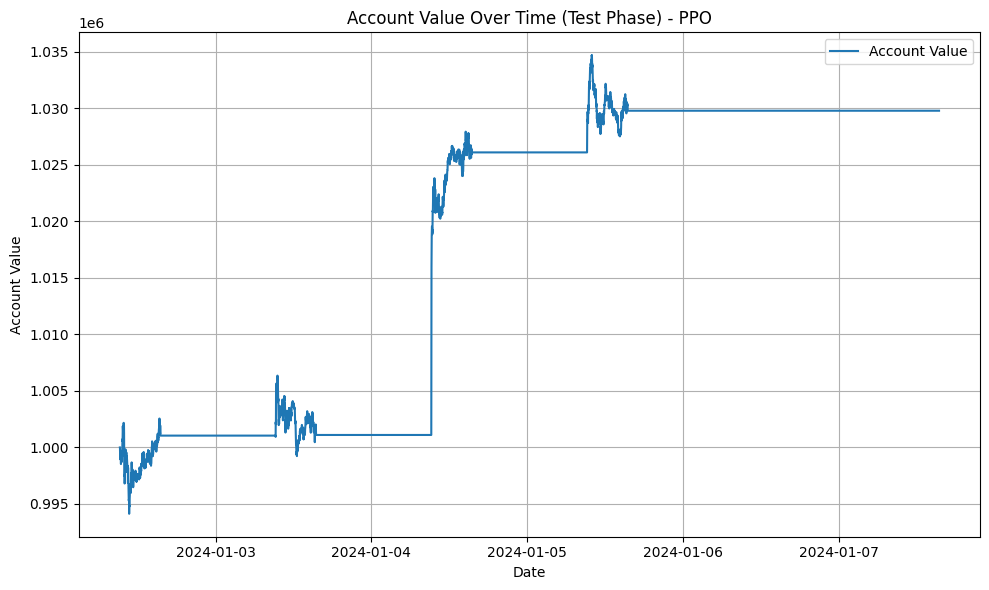

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Ensure your DataFrame has columns 'date' and 'account_value'
plt.figure(figsize=(10, 6))
plt.plot(df_account_value_ppo['date'], df_account_value_ppo['account_value'], label='Account Value')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Account Value Over Time (Test Phase) - PPO')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

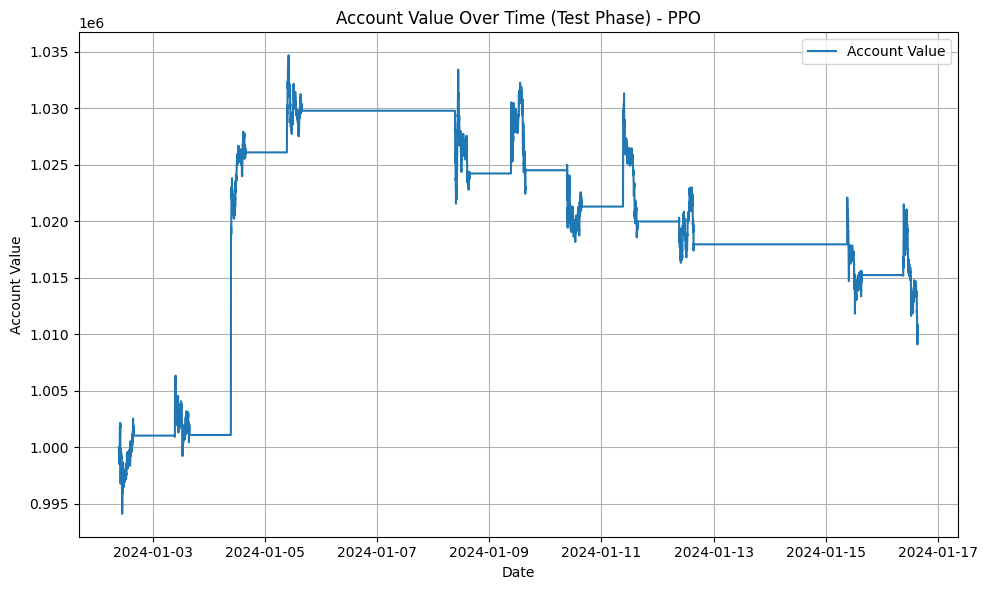

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Ensure your DataFrame has columns 'date' and 'account_value'
plt.figure(figsize=(10, 6))
plt.plot(df_account_value_ppo['date'], df_account_value_ppo['account_value'], label='Account Value')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Account Value Over Time (Test Phase) - PPO')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()